In [1]:
import re
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, GRU, concatenate
from keras import metrics
from keras import backend as K
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Custom library for the project
import sys
sys.path.insert(0, '../../../src')
import harmoutil

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load data
raw_data = harmoutil.load_pickled_data("../../../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections
augmented_data = harmoutil.transpose_and_augment_data(raw_data)
data = [harmoutil.to_sevenths(section) for section in augmented_data]
data = [harmoutil.melody_to_octave_range(section) for section in data]

In [3]:
# Isolate meaningful data
def get_notes_by_chord(beats):
    return [note for beat in beats for note in beat]

def get_chords_by_section(section):
    return [chord_info[0] for chord_info in section]

chords_by_sections = [get_chords_by_section(section) for section in data]
chords = [chord_info[0] for section in data for chord_info in section]
unique_chords = sorted(list(set(chords)))

notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in data for chord_info in section]
notes = [note for chord_notes in notes_by_chords for note in chord_notes]
unique_notes = sorted(list(set(notes)))

print("Unique notes ({}): {}".format(len(unique_notes), unique_notes))
print("Unique chords ({}): {}".format(len(unique_chords), unique_chords))

Unique notes (13): [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Unique chords (193): ['A', 'A+', 'A+7', 'A+j7', 'A-', 'A-6', 'A-7', 'A-j7', 'A6', 'A7', 'Ab', 'Ab+', 'Ab+7', 'Ab+j7', 'Ab-', 'Ab-6', 'Ab-7', 'Ab-j7', 'Ab6', 'Ab7', 'Abj7', 'Abm7b5', 'Abo', 'Abo7', 'Absus', 'Absus7', 'Aj7', 'Am7b5', 'Ao', 'Ao7', 'Asus', 'Asus7', 'B', 'B+', 'B+7', 'B+j7', 'B-', 'B-6', 'B-7', 'B-j7', 'B6', 'B7', 'Bb', 'Bb+', 'Bb+7', 'Bb+j7', 'Bb-', 'Bb-6', 'Bb-7', 'Bb-j7', 'Bb6', 'Bb7', 'Bbj7', 'Bbm7b5', 'Bbo', 'Bbo7', 'Bbsus', 'Bbsus7', 'Bj7', 'Bm7b5', 'Bo', 'Bo7', 'Bsus', 'Bsus7', 'C', 'C+', 'C+7', 'C+j7', 'C-', 'C-6', 'C-7', 'C-j7', 'C6', 'C7', 'Cj7', 'Cm7b5', 'Co', 'Co7', 'Csus', 'Csus7', 'D', 'D+', 'D+7', 'D+j7', 'D-', 'D-6', 'D-7', 'D-j7', 'D6', 'D7', 'Db', 'Db+', 'Db+7', 'Db+j7', 'Db-', 'Db-6', 'Db-7', 'Db-j7', 'Db6', 'Db7', 'Dbj7', 'Dbm7b5', 'Dbo', 'Dbo7', 'Dbsus', 'Dbsus7', 'Dj7', 'Dm7b5', 'Do', 'Do7', 'Dsus', 'Dsus7', 'E', 'E+', 'E+7', 'E+j7', 'E-', 'E-6', 'E-7', 'E-j7', 'E6', 'E7', 'Eb', 'Eb+', 'Eb+7

In [4]:
# Create categorical data mappings
note_to_int = dict([(c, i) for i, c in enumerate(unique_notes[1:])])
note_to_int[-1] = len(note_to_int)
note_to_int['<pad>'] = len(note_to_int)

int_to_note = dict([(k, v) for v, k in note_to_int.items()])

chord_to_int = dict([(c, i) for i, c in enumerate(unique_chords)])
chord_to_int['<bos>'] = len(chord_to_int)

int_to_chord = dict([(k, v) for v, k in chord_to_int.items()])

print("Melody note to integer mapping:\n {}\n".format(note_to_int))
print("Integer to melody note mapping:\n {}\n".format(int_to_note))
print("Chord label to integer mapping:\n {}\n".format(chord_to_int))
print("Integer to chord label mapping:\n {}\n".format(int_to_chord))

Melody note to integer mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, '<pad>': 13, -1: 12}

Integer to melody note mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: -1, 13: '<pad>'}

Chord label to integer mapping:
 {'Dsus': 110, 'Eb-j7': 129, 'Bsus': 62, 'G6': 168, 'Gb+7': 172, 'Dj7': 106, 'Ebo7': 135, 'Bbo': 54, 'Ab-6': 15, 'Db7': 99, 'Eb+j7': 125, 'B': 32, 'Co7': 77, 'Ab+': 11, 'D+': 81, 'Ao': 28, 'E-j7': 119, 'F-j7': 151, 'F-6': 149, 'G': 160, 'Fo': 156, 'Gj7': 186, 'Ebo': 134, 'Esus7': 143, 'Ab+j7': 13, 'Csus7': 79, 'Bm7b5': 59, 'Ab+7': 12, 'Eo7': 141, 'Gb7': 179, 'G+j7': 163, 'Cm7b5': 75, 'C7': 73, 'F+7': 146, 'C-j7': 71, 'Bb-j7': 49, 'A-7': 6, 'Eb6': 130, 'Dsus7': 111, 'F6': 152, 'C+j7': 67, 'Bbm7b5': 53, 'E6': 120, 'Gbm7b5': 181, 'C-6': 69, 'D+j7': 83, 'C': 64, 'Fsus7': 159, 'G+': 161, 'Ej7': 138, 'Cj7': 74, 'Ab': 10, 'D': 80, 'Eb-': 126, 'Bb7': 51, 'Ab-7': 16, 'Db+': 91, 'B-': 36, 'D-': 84, 'Eb7':

In [5]:
# Refine data that will actually be used
def check_if_augmented_major(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "+j7" in ch:
            return True
    return False

def check_if_NC(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "NC" in ch:
            return True
    return False

# Remove sections that involve augmented major chords (since not enough data to even allow StratifiedShuffleSplit)
section_data = [section for section in data if not check_if_augmented_major(section)]
print("Number of sections: {}\n".format(len(section_data)))

section_data = [section for section in section_data if not check_if_NC(section)]
print("Number of sections: {}\n".format(len(section_data)))

chords_by_sections = [get_chords_by_section(section) for section in section_data]
chords_data = [chord_info[0] for section in section_data for chord_info in section]
notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in section_data for chord_info in section]

Number of sections: 28836

Number of sections: 28416



In [6]:
# Define numerical variables

n_samples = len(chords_data)
n_chords = len(chord_to_int)
n_notes = len(note_to_int)
max_mel_len = max([len(mel) for mel in notes_by_chords])
chord_context_len = 7

# print("Total number of samples: {}".format(n_samples))
print("Total number of samples: {}".format(n_samples))
print("Number of distinct melody notes: {}".format(n_notes))
print("Number of distinct chord labels: {}".format(n_chords))
print("Maximum length of melody sequences for one chord: {}".format(max_mel_len))
print("Number of past chords given as input: {}".format(chord_context_len))

Total number of samples: 327708
Number of distinct melody notes: 14
Number of distinct chord labels: 194
Maximum length of melody sequences for one chord: 115
Number of past chords given as input: 7


In [7]:
# Prepare tensor data
def pad_melody(melody, max_len):
    return melody + (max_len-len(melody))*['<pad>']

def build_input_chord_sequences(chord_seq, context_len):
    padded_sequence = context_len*['<bos>'] + chord_seq
    formatted_sequences = [padded_sequence[i:i+context_len+1] for i in range(len(chord_seq))]
    return formatted_sequences

# Melody
input_melody_data = [pad_melody(melody, max_mel_len) for melody in notes_by_chords]
print("Sample input melody sequence: {}\n".format(input_melody_data[5]))

# Chords
formatted_chords_data = []
for section_chords in chords_by_sections:
    formatted_chords_data += build_input_chord_sequences(section_chords, chord_context_len)
    
input_chords_data = [ch[:-1] for ch in formatted_chords_data]
target_chords_data = [ch[-1] for ch in formatted_chords_data]
print("Sample input chord sequence: {}\n".format(input_chords_data[5]))
print("Sample target chord: {}\n".format(target_chords_data[5]))

print("Input melody: {}, Input chords: {}, Target chords: {}".format(len(input_melody_data), len(input_chords_data), len(target_chords_data)))

Sample input melody sequence: [8, 3, 6, '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

In [8]:
# Build tensors

X_melody = np.zeros((n_samples, max_mel_len, n_notes), dtype='float32')
X_labels = np.zeros((n_samples, chord_context_len, n_chords), dtype='float32')
Y_labels = np.zeros((n_samples, n_chords), dtype='float32')

for i, (input_mel, input_ch, target_ch) in enumerate(zip(input_melody_data, input_chords_data, target_chords_data)):
    Y_labels[i, chord_to_int[target_ch]] = 1
    for j, chord in enumerate(input_ch):
        X_labels[i, j, chord_to_int[chord]] = 1
        
    for j, note in enumerate(input_mel):
        X_melody[i, j, note_to_int[note]] = 1


In [9]:
# Split dataset into 80%-10%-10% train-valid-test

seed = 0

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in sss.split(X_labels, Y_labels):
    X_melody_train, X_melody_aux = X_melody[train_index], X_melody[aux_index]
    X_labels_train, X_labels_aux = X_labels[train_index], X_labels[aux_index]
    Y_labels_train, Y_labels_aux = Y_labels[train_index], Y_labels[aux_index]
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)

for valid_index, test_index in sss.split(X_labels_aux, Y_labels_aux):
    X_melody_valid, X_melody_test = X_melody_aux[valid_index], X_melody_aux[test_index]
    X_labels_valid, X_labels_test = X_labels_aux[valid_index], X_labels_aux[test_index]
    Y_labels_valid, Y_labels_test = Y_labels_aux[valid_index], Y_labels_aux[test_index]

In [10]:
# Define neural net architecture

latent_dim = 128

melody_input = Input(shape=(max_mel_len, n_notes))
melody_gru1 = GRU(latent_dim, return_sequences=True)(melody_input)
melody_gru2 = GRU(latent_dim, return_sequences=True)(melody_gru1)
melody_gru3 = GRU(latent_dim)(melody_gru2)

label_input = Input(shape=(chord_context_len, n_chords))
label_gru1 = GRU(latent_dim, return_sequences=True)(label_input)
label_gru2 = GRU(latent_dim, return_sequences=True)(label_gru1)
label_gru3 = GRU(latent_dim)(label_gru2)

concat = concatenate([melody_gru3, label_gru3])

label_hidden1 = Dense(latent_dim, activation='relu')(concat)
label_hidden2 = Dense(latent_dim, activation='relu')(label_hidden1)
label_dense = Dense(n_chords, activation='softmax')(label_hidden2)

model = Model([melody_input, label_input], label_dense)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
# SVG(model_to_dot(model).create(prog='dot', format='svg'))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 115, 14)       0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 7, 194)        0                                            
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 115, 128)      54912       input_1[0][0]                    
____________________________________________________________________________________________________
gru_4 (GRU)                      (None, 7, 128)        124032      input_2[0][0]                    
___________________________________________________________________________________________

In [11]:
# Introduce Save-Best-Performance callbacks
filepath = "Label_depth3_second_run.h5"
bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [12]:
# Train model
batch_size = 256
epochs = 150

history = model.fit([X_melody_train, X_labels_train], Y_labels_train, epochs=epochs, validation_data=([X_melody_valid, X_labels_valid], Y_labels_valid,), batch_size=batch_size, callbacks=[bp])

Train on 262166 samples, validate on 32771 samples
Epoch 1/150
262166/262166 [==============================] - 418s - loss: 2.9623 - acc: 0.3172 - val_loss: 2.3865 - val_acc: 0.4369
Epoch 2/150
262166/262166 [==============================] - 410s - loss: 2.1916 - acc: 0.4695 - val_loss: 2.0966 - val_acc: 0.4869
Epoch 3/150
262166/262166 [==============================] - 409s - loss: 1.9253 - acc: 0.5244 - val_loss: 1.8961 - val_acc: 0.5343
Epoch 4/150
262166/262166 [==============================] - 412s - loss: 1.7290 - acc: 0.5692 - val_loss: 1.7420 - val_acc: 0.5671
Epoch 5/150
262166/262166 [==============================] - 412s - loss: 1.5718 - acc: 0.6057 - val_loss: 1.6224 - val_acc: 0.6016
Epoch 6/150
262166/262166 [==============================] - 413s - loss: 1.4440 - acc: 0.6360 - val_loss: 1.5461 - val_acc: 0.6182
Epoch 7/150
262166/262166 [==============================] - 413s - loss: 1.3356 - acc: 0.6617 - val_loss: 1.4707 - val_acc: 0.6415
Epoch 8/150
262166/262166

262166/262166 [==============================] - 407s - loss: 0.4015 - acc: 0.8831 - val_loss: 1.3256 - val_acc: 0.7488
Epoch 57/150
262166/262166 [==============================] - 408s - loss: 0.4247 - acc: 0.8759 - val_loss: 1.3014 - val_acc: 0.7636
Epoch 58/150
262166/262166 [==============================] - 408s - loss: 0.4470 - acc: 0.8702 - val_loss: 1.2855 - val_acc: 0.7593
Epoch 59/150
262166/262166 [==============================] - 408s - loss: 0.3945 - acc: 0.8850 - val_loss: 1.2797 - val_acc: 0.7699
Epoch 60/150
262166/262166 [==============================] - 408s - loss: 0.4113 - acc: 0.8800 - val_loss: 1.2997 - val_acc: 0.7643
Epoch 61/150
262166/262166 [==============================] - 409s - loss: 0.3799 - acc: 0.8891 - val_loss: 1.3140 - val_acc: 0.7634
Epoch 62/150
262166/262166 [==============================] - 409s - loss: 0.4056 - acc: 0.8820 - val_loss: 1.2828 - val_acc: 0.7680
Epoch 63/150
262166/262166 [==============================] - 409s - loss: 0.4447 

262166/262166 [==============================] - 407s - loss: 0.3049 - acc: 0.9097 - val_loss: 1.3931 - val_acc: 0.7844
Epoch 118/150
262166/262166 [==============================] - 406s - loss: 0.3086 - acc: 0.9085 - val_loss: 1.4855 - val_acc: 0.7569
Epoch 119/150
262166/262166 [==============================] - 407s - loss: 0.3435 - acc: 0.8986 - val_loss: 1.3543 - val_acc: 0.7869
Epoch 120/150
262166/262166 [==============================] - 406s - loss: 0.3215 - acc: 0.9049 - val_loss: 1.3963 - val_acc: 0.7778
Epoch 121/150
262166/262166 [==============================] - 407s - loss: 0.3458 - acc: 0.8975 - val_loss: 1.3574 - val_acc: 0.7913
Epoch 122/150
262166/262166 [==============================] - 408s - loss: 0.3019 - acc: 0.9103 - val_loss: 1.3683 - val_acc: 0.7870
Epoch 123/150
262166/262166 [==============================] - 407s - loss: 0.3075 - acc: 0.9086 - val_loss: 1.4000 - val_acc: 0.7817
Epoch 124/150
262166/262166 [==============================] - 407s - loss: 

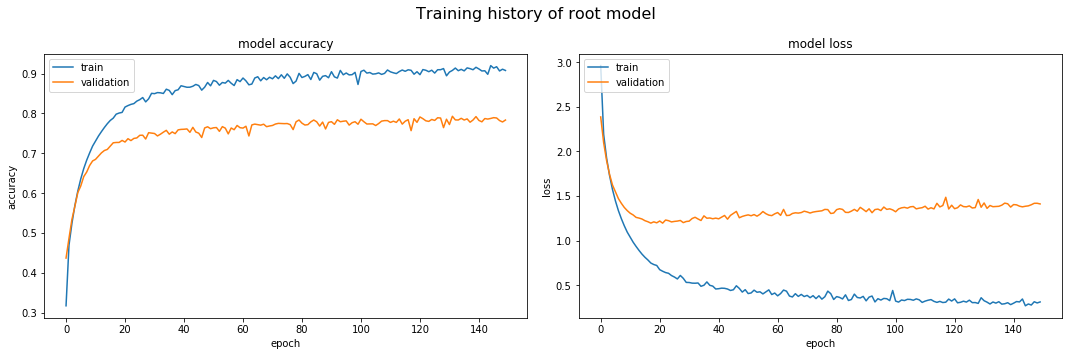

In [13]:
# Visualize model learning
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [14]:
# Load best performance model
best_model = load_model("Label_depth3_second_run.h5")

In [15]:
# Evaluate predictions in terms of labels

# Predict chords from each test sample melody
Y_labels_pred = best_model.predict([X_melody_test, X_labels_test])

# Compute accuracy and kappa score
print("Categorical accuracy of combined chord label prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_labels_test, Y_labels_pred)))
print("Kappa score of combined chord label prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_labels_test, Y_labels_pred)))

Categorical accuracy of combined chord label prediction: 0.7883
Kappa score of combined chord label prediction: 0.7830


In [16]:
# Evaluate predictions in terms of pitches

def label_to_pitch_tensors(predictions):
    predicted_chords = [int_to_chord[np.argmax(ch)] for ch in predictions]
    pitch_chords = [harmoutil.chord_to_notes(label) for label in predicted_chords]
    
    Y_pitches = np.zeros((predictions.shape[0], 12), dtype='float32')
    for i, chord_pitches in enumerate(pitch_chords):
        for j, pitch_presence in enumerate(chord_pitches):
            Y_pitches[i, j] = pitch_presence

    return Y_pitches
    
    
Y_labels_pred_pitch = label_to_pitch_tensors(Y_labels_pred)
Y_labels_test_pitch = label_to_pitch_tensors(Y_labels_test)

print("Categorical accuracy of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(Y_labels_test_pitch, Y_labels_pred_pitch)))
print("Kappa score of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(Y_labels_test_pitch, Y_labels_pred_pitch)))

Categorical accuracy of combined chord pitch prediction: 0.9241
TP: 113555 TN: 249849 FP: 15043 FN: 14805
Kappa score of combined chord pitch prediction: 0.8275
